<a href="https://colab.research.google.com/github/joaco2v/ProyectoDS-JoaquinVicuna/blob/main/ProyectoDSParteI_JoaquinVicuna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto DS Parte I - Joaquín Vicuña Vicencio
## Contexto:
### En Chile, al ser un país sismico, existe una creencia que por los ultimos eventos de gran magnitud, es normal que ocurran en horarios no hábiles. Por otro lado existe un vicio de lenguaje en el cual se hace la distinción de aquellos sismos que son destructivos denominandolos "Terremotos" de los sismos que no son destructivos, a estos ultimos se les llama "Temblores".


## Hipotesis y preguntas:
#### 1) Realizar un analisis estadistico de sismos ocurridos en Chile, desde el 01-01-1950 hasta el día 24-02-2025 que tengan magnitud > 4.5 en escala Richter. y ver la proporción entre los terremotos (sismos >= 7M), es decir, verificar cuantos de estos eventos son terremotos.En aquellos sismos denominados "Terremotos" según el contexto anterior, ver que tan probable es que estos puedan ocurrir en horarios no habiles (esto incluye si es en fin de semana o días feriados).

#### 2) Realizar un analisis para ver con cuanta perioricidad ocurre un evento de gran magnitud en Chile en un analisis temporal.

### Cargamos todas las librerías que utilizaremos

In [ ]:
import pandas as pd
from datetime import datetime, time
import pytz
from workalendar.america import Chile
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#Generamos variable con registros de sismos < 4.5
url_df_github = "https://raw.githubusercontent.com/joaco2v/ProyectoDS-JoaquinVicuna/refs/heads/main/sismos_chile.csv"
#Cargamos csv
df = pd.read_csv(url_df_github)
#Se fija fecha en zona horaria UTC
df["Fecha UTC"] = pd.to_datetime(df["time"],utc=True)
#Generamos una columna con la zona horaria chilena
santiago_tz = pytz.timezone("America/Santiago")
df["Fecha UTC CL"] = df["Fecha UTC"].dt.tz_convert(santiago_tz)

#Se determinará si el sismo fue en un horario habil o inhabil

cal = Chile()

#Se define funcion con los horarios habiles e inhabiles

def es_habil(fecha_hora):
    fecha = fecha_hora.date()
    hora = fecha_hora.time()
    dia_semana = fecha_hora.weekday() #0 = Lunes, 6 = Domingo

    #Verificamos si es fin de semana es decir si es Sabado o Domingo

    if dia_semana >=5:
        return "No habil"

    #Verificamos si es dia feriado

    if cal.is_holiday(fecha):
        return "No habil"

    #Verificamos horario laboral definido (7:30 AM a 7:30 PM)
    if time(7,30) <= hora <= time(19,30):
        return "Habil"
    else:
        return "No habil"

df["Horario_Habil"] = df["Fecha UTC CL"].apply(es_habil)

#Creamos una columna que tenga día de semana en que ocurrió el evento

# Usamos un mapeo manual para evitar cualquier dependencia a otras librerias
dias_semana = {
    0: "Lunes",
    1: "Martes",
    2: "Miércoles",
    3: "Jueves",
    4: "Viernes",
    5: "Sábado",
    6: "Domingo"
}

# Extraemos el número del día (0=Lunes, 6=Domingo)
df["Num_Dia"] = df["Fecha UTC CL"].dt.weekday  # weekday ya considera la zona horaria

# Mapeamos a nombres en español
df["Dia_Semana"] = df["Num_Dia"].map(dias_semana)

# Eliminamos la columna auxiliar si no la necesitas
df.drop("Num_Dia", axis=1, inplace=True)

#Formateamos las columnas finales
df["Fecha UTC CL"]= df["Fecha UTC CL"].dt.strftime("%Y-%m-%d %H:%M:%S")

#Ahora definiremos si es terremoto según la semantica chilena,
# es decir ajustaremos cualquier sismo > 7  como terremoto, y si es < 7 será considerado temblor
def es_terremoto(mag):
    if mag < 7:
        return False
    else:
        return True


def temblor_o_terremoto(mag):
    if mag < 7:
        return "Temblor"
    else:
        return "Terremoto"


df["Terremoto"] = df["mag"].apply(es_terremoto)
df["Temblor o Terremoto"] = df["mag"].apply(temblor_o_terremoto)

#Luego, guardamos el resultado:
df.to_csv("sismos_chile_actualizado.csv",index=False)

### Una vez realizada la agregación de columnas, procedemos a construir gráficos, en primer lugar, será el analisis estadistico de sismos, en segundo lugar el analisis de horarios de "Terremotos" y finalmente el analisis de tiempo de sismos vs terremotos.

#### En primer lugar, crearemos un histograma con las distintas magnitudes y luego de una distribucón de sismos por dia de la semana:

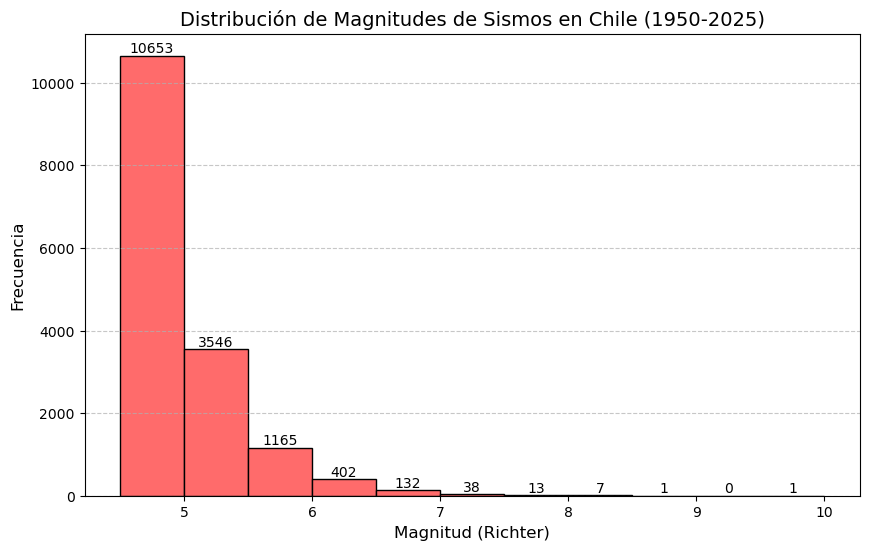

Cantidad de temblores: 15898 (99.62%)
Cantidad de terremotos: 60 (0.38%)


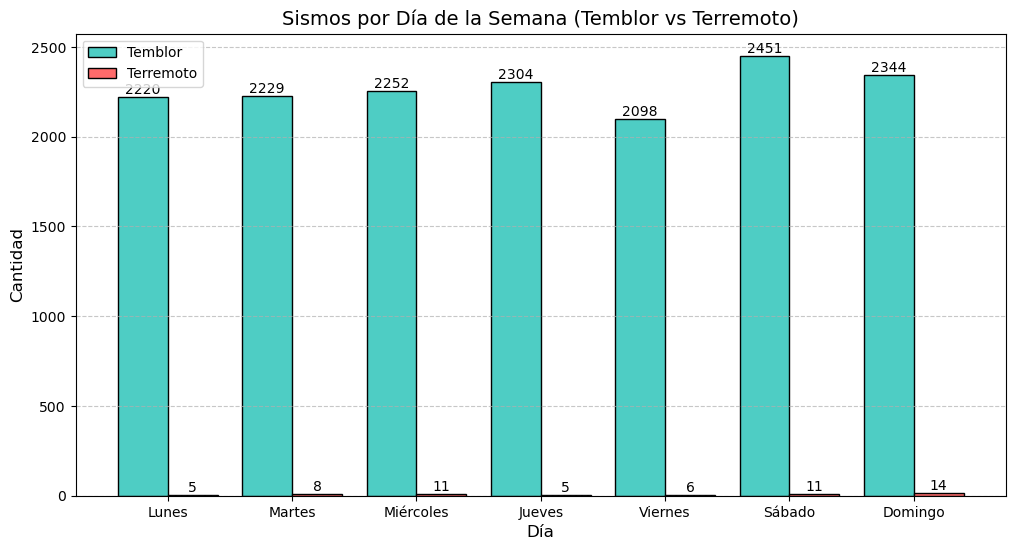

In [ ]:
# Histograma de sismos
plt.figure(figsize=(10, 6))
counts, bins, patches = plt.hist(df["mag"], bins=[4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9, 9.5, 10], color="#FF6B6B", edgecolor="black")
plt.title("Distribución de Magnitudes de Sismos en Chile (1950-2025)", fontsize=14)
plt.xlabel("Magnitud (Richter)", fontsize=12)
plt.ylabel("Frecuencia", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Añadir etiquetas a las barras
for count, bin in zip(counts, bins):
    plt.text(bin + 0.25, count + 0.5, str(int(count)), ha='center', va='bottom', fontsize=10)

plt.show()

# Conteo de temblores y terremotos
conteo_temblor = df[df["Temblor o Terremoto"] == "Temblor"].shape[0]
conteo_terremoto = df[df["Temblor o Terremoto"] == "Terremoto"].shape[0]
total_sismos = df.shape[0]

porcentaje_temblor = (conteo_temblor / total_sismos) * 100
porcentaje_terremoto = (conteo_terremoto / total_sismos) * 100

print(f"Cantidad de temblores: {conteo_temblor} ({porcentaje_temblor:.2f}%)")
print(f"Cantidad de terremotos: {conteo_terremoto} ({porcentaje_terremoto:.2f}%)")

# Verificación de la cantidad de terremotos en la distribución por día de la semana
conteo_dias_temblor = df[df["Temblor o Terremoto"] == "Temblor"]["Dia_Semana"].value_counts().reindex(dias_semana.values())
conteo_dias_terremoto = df[df["Temblor o Terremoto"] == "Terremoto"]["Dia_Semana"].value_counts().reindex(dias_semana.values())

assert conteo_terremoto == conteo_dias_terremoto.sum(), "La cantidad de terremotos no coincide con la distribución por día de la semana."

# Distribución de sismos por día de la semana con separación por categoría
plt.figure(figsize=(12, 6))
bar_width = 0.4
r1 = range(len(conteo_dias_temblor))
r2 = [x + bar_width for x in r1]

plt.bar(r1, conteo_dias_temblor.values, color="#4ECDC4", width=bar_width, edgecolor="black", label="Temblor")
plt.bar(r2, conteo_dias_terremoto.values, color="#FF6B6B", width=bar_width, edgecolor="black", label="Terremoto")

plt.title("Sismos por Día de la Semana (Temblor vs Terremoto)", fontsize=14)
plt.xlabel("Día", fontsize=12)
plt.ylabel("Cantidad", fontsize=12)
plt.xticks([r + bar_width / 2 for r in range(len(conteo_dias_temblor))], dias_semana.values())
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Añadir etiquetas a las barras
for i in range(len(conteo_dias_temblor)):
    plt.text(r1[i], conteo_dias_temblor[i] + 0.5, str(conteo_dias_temblor[i]), ha='center', va='bottom', fontsize=10)
    plt.text(r2[i], conteo_dias_terremoto[i] + 0.5, str(conteo_dias_terremoto[i]), ha='center', va='bottom', fontsize=10)

plt.show()


#### Ahora veremos el analisis de terremotos en horario no hábil. En primer lugar veremos los porcentajes de terremotos en horario no habil y en horario hábil, posteriormente veremos la distribución de terremotos por día de la semana

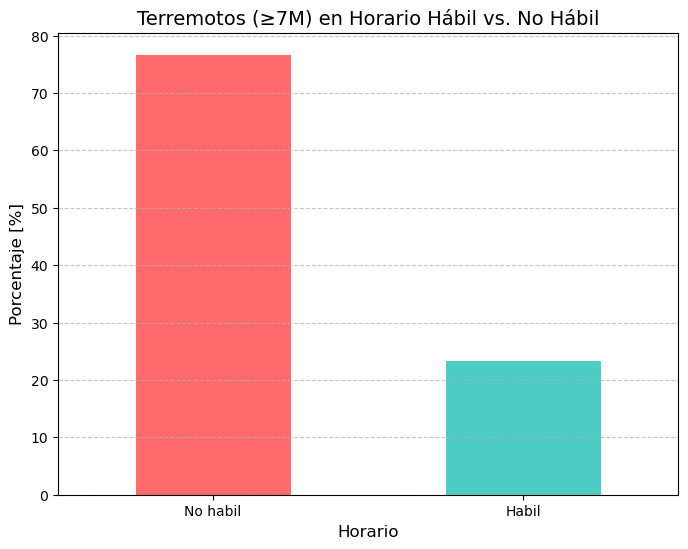

Los porcentajes de terremotos en horario hábil vs horario no hábil son los siguientes: 

% Terremotos en horario No hábil: 76.67 %
% Terremotos en horario Hábil: 23.33 %


In [ ]:
terremotos = df[df["Terremoto"]]
conteo_horario = terremotos["Horario_Habil"].value_counts(normalize=True) * 100

plt.figure(figsize=(8, 6))
conteo_horario.plot(kind="bar", color=["#FF6B6B", "#4ECDC4"])
plt.title("Terremotos (≥7M) en Horario Hábil vs. No Hábil", fontsize=14)
plt.xlabel("Horario", fontsize=12)
plt.ylabel("Porcentaje [%]", fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

print("Los porcentajes de terremotos en horario hábil vs horario no hábil son los siguientes: \n")
print("% Terremotos en horario No hábil: {:.2f} %".format(conteo_horario.values[0]))
print("% Terremotos en horario Hábil: {:.2f} %".format(conteo_horario.values[1]))


C:\Users\jvicuna1\AppData\Local\Temp\ipykernel_4080\1695168931.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=conteo_dias.index, y=conteo_dias.values, palette="viridis")


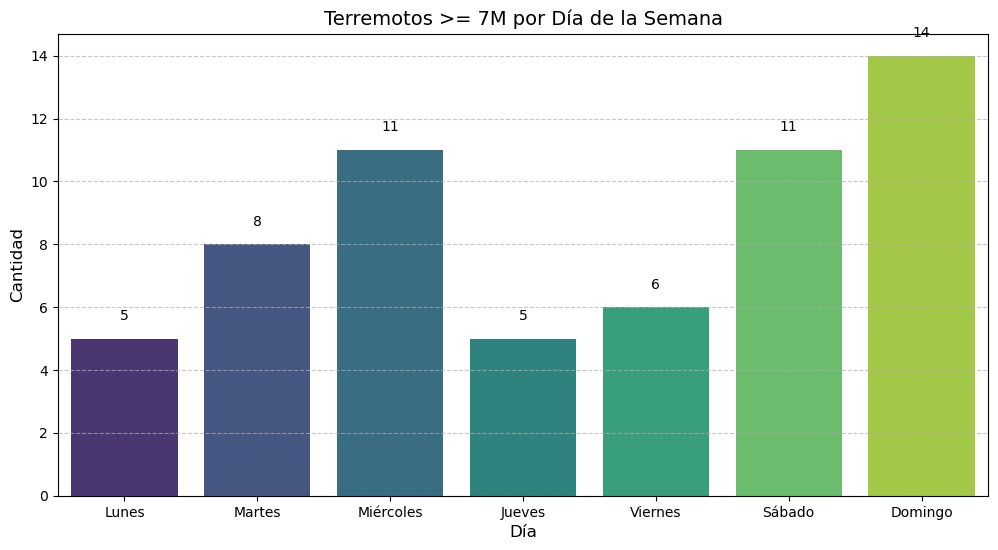

In [ ]:
conteo_dias = terremotos["Dia_Semana"].value_counts().reindex([
    "Lunes", "Martes", "Miércoles", "Jueves", "Viernes", "Sábado", "Domingo"
], fill_value=0)

plt.figure(figsize=(12, 6))
ax = sns.barplot(x=conteo_dias.index, y=conteo_dias.values, palette="viridis")
plt.title("Terremotos >= 7M por Día de la Semana", fontsize=14)
plt.xlabel("Día", fontsize=12)
plt.ylabel("Cantidad", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Añadir etiquetas a las barras
for i in range(len(conteo_dias)):
    ax.text(i, conteo_dias[i] + 0.5, str(conteo_dias[i]), ha='center', va='bottom', fontsize=10)

plt.show()

### Hipotesis 1: Aca ya tenemos un primer vistazo, al realizar un analisis a traves de la distribución por días de la semana, vemos que las primeras 3 mayorias serían los días domingo, sábado y miércoles, con 14, 11 y 11 respectivamente, lo cual tiene un primer pilar nuestra hipotesis, si considereamos los fin de semana como horario no hábil. Además vemos que hay una diferencia abismal en la distribución de terremotos en horario no hábil vs los en horario hábil. Esto puede repercutir en que puede haber una diferencia en que tan preparada está la población para enfrentar eventos de gran magnitud en entornos de trabajo y escuelas. Pues uno podría suponer que culturalmente según los hechos, no existiria la misma preparación.

#### Ahora, finalizaremos con el analisis con los analisis de tiempo, partiremos analizando una serie temporal de los terremotos >= 7 para luego ver el tiempo que pasa entre un terremoto y otro.

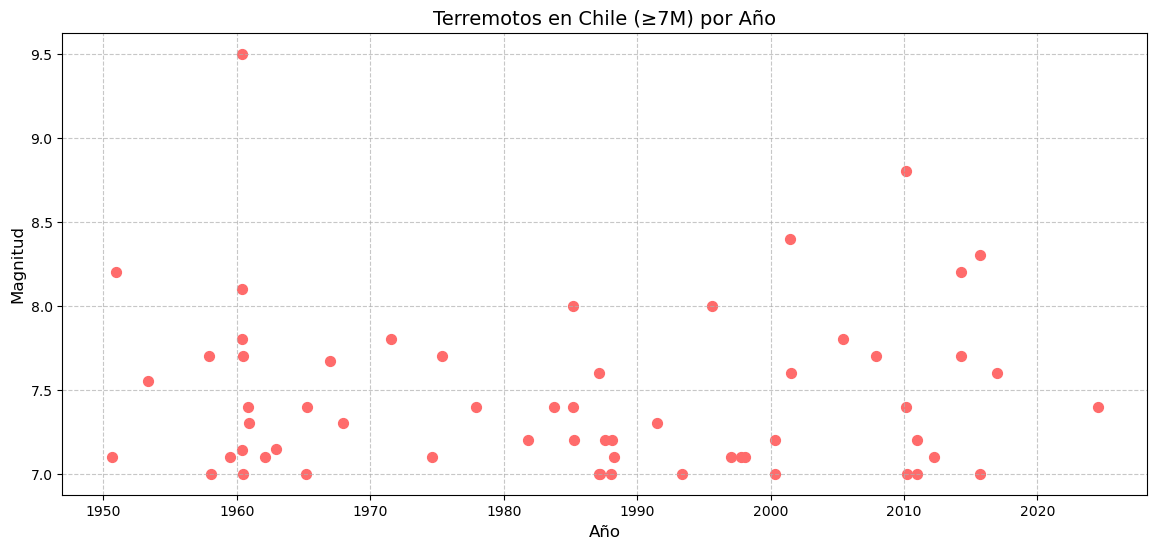

In [ ]:
terremotos["Fecha"] = pd.to_datetime(terremotos["time"])
terremotos = terremotos.sort_values("Fecha")

plt.figure(figsize=(14, 6))
plt.scatter(terremotos["Fecha"], terremotos["mag"], color="#FF6B6B", s=50)
plt.title("Terremotos en Chile (≥7M) por Año", fontsize=14)
plt.xlabel("Año", fontsize=12)
plt.ylabel("Magnitud", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

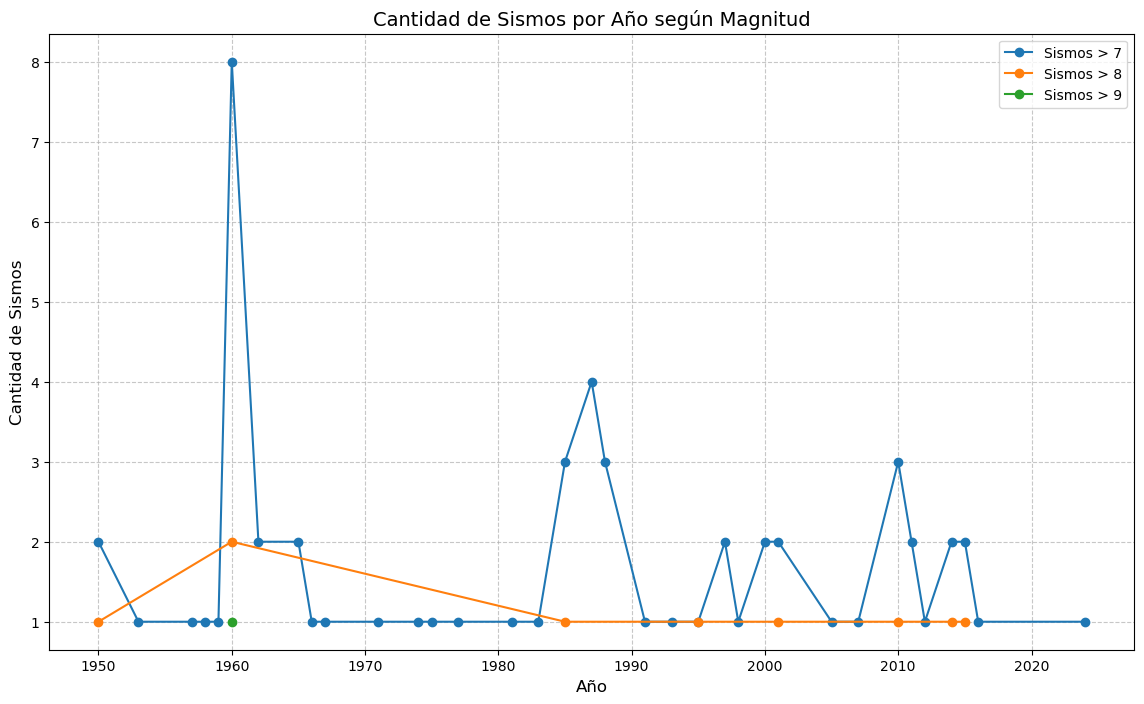

In [ ]:
# Filtramos los terremotos por magnitud
terremotos_sobre_7 = df[df["mag"] >= 7]
terremotos_sobre_8 = df[df["mag"] >= 8]
terremotos_sobre_9 = df[df["mag"] >= 9]

# Contamos la cantidad de sismos por año para cada categoría
conteo_terremotos_sobre_7 = terremotos_sobre_7.groupby(terremotos_sobre_7["Fecha UTC"].dt.year).size()
conteo_terremotos_sobre_8 = terremotos_sobre_8.groupby(terremotos_sobre_8["Fecha UTC"].dt.year).size()
conteo_terremotos_sobre_9 = terremotos_sobre_9.groupby(terremotos_sobre_9["Fecha UTC"].dt.year).size()

# Creamos el gráfico de series de tiempo
plt.figure(figsize=(14, 8))
plt.plot(conteo_terremotos_sobre_7.index, conteo_terremotos_sobre_7.values, label="Sismos > 7", marker='o')
plt.plot(conteo_terremotos_sobre_8.index, conteo_terremotos_sobre_8.values, label="Sismos > 8", marker='o')
plt.plot(conteo_terremotos_sobre_9.index, conteo_terremotos_sobre_9.values, label="Sismos > 9", marker='o')

plt.title("Cantidad de Sismos por Año según Magnitud", fontsize=14)
plt.xlabel("Año", fontsize=12)
plt.ylabel("Cantidad de Sismos", fontsize=12)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()


#### Hipotesis 2: Vemos aca que aproximadamente cada 25 años hay eventos de mayor magnitud, es decir existe una perioricidad en Terremotos, sin embargo habria que agregar un analisis geografico para determinar si son o no en zonas geograficas similares o colindantes
